In [1]:
#!pip install lifetimes

import pandas as pd
import numpy as np

import pymysql
from sqlalchemy import create_engine
from sqlalchemy import text
import pandas as pd
import getpass

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest, poisson

from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_period_transactions
from lifetimes import BetaGeoFitter, GammaGammaFitter

from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

https://archive.ics.uci.edu/dataset/502/online+retail+ii

As i reviewed the data further in sql, I decided I will only focus on sales first.

suspected returns make up less than 3% of all the transactions.

In [2]:
df2 = pd.read_csv('sales_data_clean.csv')

In [3]:
df2.date.max()

'2010-12-09 20:01:00'

I am using lifetimes to help me produce a basic frequency/recency analysis using the BG/NBD model so I can then use the Gamma-Gamma model to predict CLV.

In [4]:
summary = summary_data_from_transaction_data(df2, 'cust_id', 'date',
          monetary_value_col='total_price', observation_period_end='2010-12-31')
summary

,frequency,recency,T,monetary_value
cust_id,,,,
12346,6.0,196.0,382.0,47.143333
12347,1.0,37.0,61.0,711.790000
12348,0.0,0.0,95.0,0.000000
12349,2.0,182.0,246.0,801.310000
12351,0.0,0.0,32.0,0.000000
...,...,...,...,...
18283,4.0,276.0,315.0,135.105000
18284,0.0,0.0,88.0,0.000000
18285,0.0,0.0,317.0,0.000000


In [53]:
#fitting model. 0.5 gave me the best model
bgf = BetaGeoFitter(penalizer_coef=0.05)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 4314 subjects, a: 0.00, alpha: 63.41, b: 0.00, r: 0.69>

In [54]:
summary['pred_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    182, summary['frequency'], summary['recency'], summary['T']).round(2)
print(summary.head())

         frequency  recency      T  monetary_value  pred_purchases
cust_id                                                           
12346          6.0    196.0  382.0       47.143333            2.73
12347          1.0     37.0   61.0      711.790000            2.47
12348          0.0      0.0   95.0        0.000000            0.79
12349          2.0    182.0  246.0      801.310000            1.58
12351          0.0      0.0   32.0        0.000000             NaN


C:\Users\NessaJay\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [55]:
#splitting test and train data
calibration_holdout = calibration_and_holdout_data(
    df2, 'cust_id', 'date', 
    calibration_period_end='2010-09-01', 
    observation_period_end='2010-12-09'
)

In [56]:
#fit model with calibration data
bgf.fit(calibration_holdout['frequency_cal'], calibration_holdout['recency_cal'], calibration_holdout['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 3323 subjects, a: 0.00, alpha: 54.42, b: 0.01, r: 0.62>

In [57]:
calibration_holdout['predicted_purchases_holdout'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    100,  # Number of days in the holdout period
    calibration_holdout['frequency_cal'], 
    calibration_holdout['recency_cal'], 
    calibration_holdout['T_cal']
).round(2)

C:\Users\NessaJay\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
#these are the purchases the model predicted
summary[['pred_purchases']].head()

,pred_purchases
cust_id,
12346,2.78
12347,2.61
12348,0.55
12349,1.54
12351,NaN


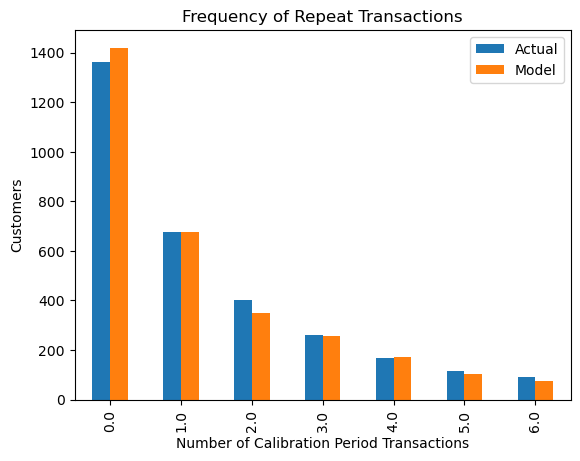

In [59]:
#evaluation our model, our model for the most part is lining up with our real numbers
from lifetimes.plotting import plot_period_transactions

_ = plot_period_transactions(bgf) 

In [60]:
calibration_holdout.fillna(0, inplace=True)

# summary['monetary_value'] = summary['monetary_value'].apply(lambda x: 0.1 if x < 0.5 else x)
# summary['predicted_purchases'] = summary['predicted_purchases'].apply(lambda x: 0.1 if x < 0.5 else x)

In [61]:
#the model gets great scores

mae = mean_absolute_error(calibration_holdout['frequency_holdout'], calibration_holdout['predicted_purchases_holdout'])
rmse = np.sqrt(mean_squared_error(calibration_holdout['frequency_holdout'], calibration_holdout['predicted_purchases_holdout']))
y_true = calibration_holdout['frequency_holdout']
y_pred = calibration_holdout['predicted_purchases_holdout']

r2 = r2_score(y_true, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f"R-squared (R^2) Score: {r2}")

Mean Absolute Error (MAE): 0.9970749322900992
Root Mean Squared Error (RMSE): 1.6340111064854992
R-squared (R^2) Score: 0.535356961939057


In [62]:
#to get clv and use gamma gamma we need to look at only returning customers, and correlation should be low
returning_customers = summary[summary['frequency']>0]
returning_customers[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.186686
frequency,0.186686,1.000000


In [63]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers['frequency'],
        returning_customers['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2818 subjects, p: 2.21, q: 3.62, v: 501.98>


In [64]:
returning_customers['est_trans_value'] = ggf.conditional_expected_average_profit(
        returning_customers['frequency'],
        returning_customers['monetary_value']
    )

In [65]:
returning_customers['clv'] = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    returning_customers['frequency'],
    returning_customers['recency'],
    returning_customers['T'],
    returning_customers['monetary_value'],
    time=6, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
)

In [66]:
# predictions for next 6 months of purchases, est_trans_value and clv now included

returning_customers

,frequency,recency,T,monetary_value,pred_purchases,est_trans_value,clv
cust_id,,,,,,,
12346,6.0,196.0,382.0,47.143333,2.73,109.177684,287.819997
12347,1.0,37.0,61.0,711.790000,2.47,554.575835,1338.017710
12349,2.0,182.0,246.0,801.310000,1.58,660.029458,1001.937734
12352,1.0,17.0,49.0,200.050000,2.73,320.759930,860.797932
12356,2.0,44.0,81.0,1325.905000,3.38,989.068913,3330.518236
...,...,...,...,...,...,...,...
18276,4.0,337.0,386.0,275.652500,1.90,309.250222,564.417372
18277,2.0,97.0,151.0,366.265000,2.28,387.158063,859.462839
18283,4.0,276.0,315.0,135.105000,2.25,200.900160,437.135654


In [67]:
returning_customers.to_csv('returning_customers.csv', index=False)

In [68]:
returning_customers.describe()

,frequency,recency,T,monetary_value,pred_purchases,est_trans_value,clv
count,2818.000000,2818.000000,2818.000000,2818.000000,2818.000000,2818.000000,2818.000000
mean,4.502129,205.538325,285.853797,415.410091,2.639045,428.154584,1277.388278
std,6.959299,111.475772,101.380366,453.069984,2.821505,352.089976,4124.552573
min,1.000000,1.000000,28.000000,7.900000,0.670000,43.814285,121.552295
25%,1.000000,113.000000,221.000000,196.471250,1.220000,283.057849,404.530589
50%,3.000000,214.000000,311.000000,311.660000,1.920000,353.302325,665.633675
75%,5.000000,304.000000,381.000000,473.963036,3.097500,457.340747,1151.304905
max,127.000000,373.000000,395.000000,8416.400000,50.690000,8043.319950,132624.875526


Most returning customers in the last year made about 5 purchases. Most of their last purchases were 200-300 days ago, around Christmas time. The average revenue generated by each customer per transaction sits around $440.

Since we only have historical data for one year of purchases, I decided to use the model to make predictions focused on the next 6 months.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(returning_customers[['frequency', 'recency', 'T','monetary_value']], returning_customers['clv'], test_size=0.2)

In [ ]:
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

# make predictions on the testing set
y_pred = linreg.predict(X_test)

In [ ]:
#terrible scores for linreg

print("R2:",metrics.r2_score(y_test, y_pred))

# calculate MAE using scikit-learn
print("MAE:",metrics.mean_absolute_error(y_test,y_pred))

#calculate mean squared error
print("MSE",metrics.mean_squared_error(y_test, y_pred))
# compute the RMSE of our predictions
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


In [ ]:
# Initialize the BetaGeoFitter model
bgf = BetaGeoFitter()

# Define the parameter grid
param_grid = {
    'penalizer_coef': [0.0, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
    'alpha': [0.0, 0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
    'beta': [0.0, 0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
    'r': [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
}

# Define scoring metric (negative log likelihood is common for lifetimes models)
scoring = metrics.get_scorer_names()

# Initialize GridSearchCV with the model, parameter grid, and scoring
grid_search = GridSearchCV(estimator=bgf, param_grid=param_grid, scoring=scoring, cv=5, refit=False)

In [ ]:
# Fit the grid search to find the best parameters

values= returning_customers['frequency'], returning_customers['recency'], returning_customers['T']
grid_search.fit(values)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best {}:".format(scoring), grid_search.best_score_)

In [ ]:
#my data is not poisson distribution

plt.figure(figsize=(8, 6))
plt.hist(summary['frequency'], bins=20, density=True, alpha=0.7, color='blue')
plt.xlabel('Frequency')
plt.ylabel('Density')
plt.title('Histogram of Frequency')
plt.grid(True)
plt.show()

data = summary['frequency']

lambda_est = data.mean()
dist = poisson(mu=lambda_est)

# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = kstest(data, dist.cdf)

print(f"Kolmogorov-Smirnov test statistic: {ks_statistic}")
print(f"P-value: {p_value}")